In [388]:
!rm -rf Eunomia
!git clone https://github.com/ouaguenouni/Eunomia
!pip install -r Eunomia/requirements.txt

Cloning into 'Eunomia'...
remote: Enumerating objects: 445, done.
remote: Counting objects: 100% (445/445), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 445 (delta 341), reused 396 (delta 292), pack-reused 0
Receiving objects: 100% (445/445), 2.88 MiB | 2.07 MiB/s, done.
Resolving deltas: 100% (341/341), done.


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Eunomia.preferences import *
from Eunomia.additive_functions import *
from Eunomia.alternatives import *
from Eunomia.sampling import *
from Eunomia.mcmc import *
#from Eunomia.degree import *
from Eunomia.experiments import *
from Eunomia.ssb import * 
from Eunomia.graph_utils import * 

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
pyro.set_rng_seed(1)

## Introduction and formalism

### Features
- Let $\mathcal{F} = \{a_0, a_1, \ldots, a_n\}$ be the set of features, where each $a_i$ represents a distinct attribute.

### Alternatives
- The set of all alternatives, $\mathcal{A}$, is defined as the power set of $\mathcal{F}$, i.e., 
  $$
  \mathcal{A} = 2^{\mathcal{F}}
  $$
  This represents all possible combinations of the attributes in $\mathcal{F}$.

### The interaction set $\theta$
- Let $\theta$ be a set that contains all the interactions considered by the model. 
- Each element in $\theta$ represents a specific interaction or combination of features.

### Preferences
- Preferences among the alternatives are represented by a set $R$ containing ordered pairs $(A, B)$, where $A$ is preferred over $B$. Formally,
  $$
  R = \{(A_0, B_0), \ldots, (A_r, B_r)\}
  $$
  Here, $A_i, B_i \in \mathcal{A}$ and the pair $(A_i, B_i)$ signifies that alternative $A_i$ is preferred to alternative $B_i$.

## Non transitive $\phi$ function

The function $\phi$ aims at modelling a non-transitive model of interactions, the function is parameterized by $\theta$ the set of considered interactions and $M$ a matrix that contains the parameters for each unique pair of attributes and their presence/absence states.
The value associated to a pair of alternatives $A,B \in \mathcal{A}$ is the following : 
$$
\Phi_{\theta, M}(X,Y) = \sum_{A \in \theta} \sum_{B \in \theta} M[A,B, I_X(A), I_Y(B)]
$$
where $I_X(A)$ is the indicator of $A \subset X$

In the implementation, since the function is symetrical we use a dictionnary rather than a matrix to store the parameters since each pair $(A,B)$ is stored once (we don't have (B,A) if we have (A,B)).

## SSB Model
The SSB Model is defined having : 
- A set of interactions $\theta$.
- A vector of weights $w$ that associate to each element in $\theta$ the utility of having $\theta$ in an alternative.
- The matrix $M$ where $M[A,B,X,Y]$ is the utility of having A in X and B in Y based on their presence (1) or absence (0).
The function is thus defined as follow: 

$$
f_{\theta, w, M}(X, Y) = \left[ \sum_{A \in \theta} w_A \cdot I_X(A) - w_B \cdot I_Y(B) \right] + \left[ \sum_{A \in \theta} \sum_{B \in \theta} M[A, B, I_X(A), I_Y(B)] \right]
$$

The first part of the model is named the **additive** part and the second one the **billinear** part.

## Optimizing an SSB model given a set of pairwise preferences

Let's assume we have a fixed $\theta$ and a fixed $R$. In this part we explain how to optimize an SSB model given $R$ and $\theta$. 

We will use first a maximum likelihood estimation (MLE), to do so we start by defining the likelihood. To define it we recall that we must have $f(A,B) > 0$ if $A \succ B$, $f(A,B) < 0$ if $B \succ A$ and $f(A,B) = 0$ otherwise. 

An easy way to define the likelihood is to transform the value $f$ to a probability using the sigmoid function 

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

This function maps a real-valued number into a range between 0 and 1.
And so the likelihood of a given preference $A \succ B$ is given by :
$$
P(A \succ B| \theta, w, M) = \sigma(f_{\theta, w, M}(A, B))
$$
And the log-likelihood of a set $R$ is : 
$$
\mathcal{L}(A \succ B| \theta, w, M) = \sum_{A,B \in R} \log P(A \succ B| \theta, w, M) = \sum_{A,B \in R} \log \sigma(f_{\theta, w, M}(A, B))
$$

This function is convex and derivable so it could be optimized using a gradient descent.
However, since the non transitive part could single-handedly model an additive model, we choose to decompose the optimization process in two subprocesses : 


We start by otimizing according to $\nabla_w f(X, Y)  = \frac{\partial f(X, Y)}{\partial w}$ to maximize the likelihood while using only the additive part.

In [444]:
n = 3
theta = generate_additive_theta(n, 1)
s = [
    [(0,), (1,)],
    [(1,), (2,)],
    [(2,), (0,)],
]
model = SSBModel(theta)

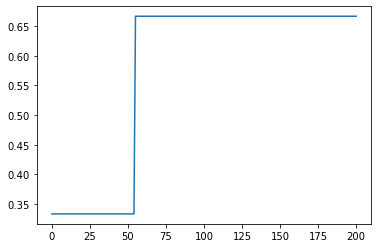

In [445]:
losses = fit_w_mle(model, s)
plt.plot(np.arange(len(losses)),losses) 

In [446]:
model.display_model()

w[2] = 1.4158474206924438


as expected the optimization process starts by maximizing the number of represented preferences using only the additive part, which on this simple example is 2/3 since we have one non transitive arc. 
The we optimize according to $\nabla_M f(X, Y)  = \frac{\partial f(X, Y)}{\partial M}$.

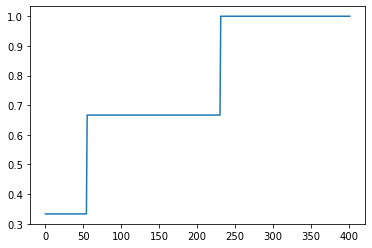

In [453]:
#losses = losses + fit_M_mle(model, s)
plt.plot(np.arange(len(losses)),losses)
plt.savefig("figs/bilinear_example.jpg")

With the non transitive part, the model is able to represent all the preferences including the non-transitive ones.

## Adding the posterior

To ensure that the model remains the sparsest possible, we can use two regularization terms, one for each part of the model : 
- For the additive part we use a $L_2$ regularization which is equivalent to supposing that the prior over $w$ is a gaussian one i.e 
$$
P(w) = \mathcal{N}(0, \lambda_1)
$$
So the regularization is done by adding $\lambda_1 w^T w$ to the loss.

- For the transitive part we use a $L_1$ regularization which is equivalent to supposing that the prior over $w$ is a laplacian one i.e 
$$
P(M) = \mathcal{L}(0, \lambda_2)
$$
So the regularization is done by adding $\lambda_2 |M|$ to the loss.


Now we will compare the models yielded by the MLE and the MAP optimization processes.

In [454]:
model_mle = SSBModel(theta)
losses_1 = fit_w_mle(model_mle, s)
model_mle.display_model()

w[0] = 0.3374236226081848
w[2] = 2.94472599029541


In [455]:
losses_2 = fit_M_mle(model_mle, s)
losses = losses_1 + losses_2
model_mle.display_model()

w[0] = 0.3374236226081848
w[2] = 2.94472599029541
C[(0,), (1,), 0, 0] = 3.55045747756958 
C[(0,), (1,), 1, 1] = 1.673614740371704 
C[(0,), (2,), 0, 0] = 1.2600133419036865 
C[(0,), (2,), 0, 1] = 3.7117857933044434 
C[(0,), (2,), 1, 0] = 1.673614740371704 
C[(1,), (2,), 0, 0] = 1.467850923538208 
C[(1,), (2,), 1, 1] = 3.7117857933044434 


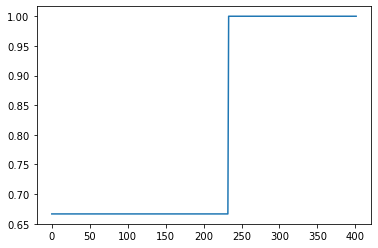

In [456]:
plt.plot(np.arange(len(losses)),losses) 

In [535]:
model_map = SSBModel(theta)
losses_1 = fit_w_map(model_map, s, lambda_1 = 1e-3, num_epochs=1000)
model_map.display_model()

w[0] = 4.080715656280518


In [536]:
losses_2 = fit_M_map(model_map, s, lambda_2 = 5e-4, num_epochs=1000)
losses = losses_1 + losses_2
model_map.display_model()

w[0] = 4.080715656280518
C[(0,), (1,), 0, 0] = 5.025367259979248 
C[(0,), (2,), 0, 0] = 4.658667087554932 
C[(1,), (2,), 0, 0] = 5.025396823883057 


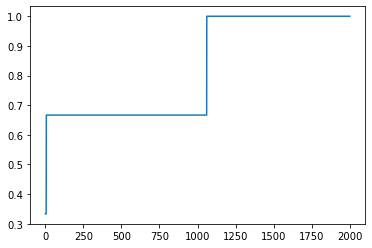

In [537]:
plt.plot(np.arange(len(losses)),losses) 

Each of the model converges and is able to represent all the preferences. 
Now let's examine the differences between the parameters, we chose not to display the parameter that are below 1e-2 for visualisation purposes.

In [538]:
model_mle.display_model()

w[0] = 0.3374236226081848
w[2] = 2.94472599029541
C[(0,), (1,), 0, 0] = 3.55045747756958 
C[(0,), (1,), 1, 1] = 1.673614740371704 
C[(0,), (2,), 0, 0] = 1.2600133419036865 
C[(0,), (2,), 0, 1] = 3.7117857933044434 
C[(0,), (2,), 1, 0] = 1.673614740371704 
C[(1,), (2,), 0, 0] = 1.467850923538208 
C[(1,), (2,), 1, 1] = 3.7117857933044434 


In [539]:
model_map.display_model()

w[0] = 4.080715656280518
C[(0,), (1,), 0, 0] = 5.025367259979248 
C[(0,), (2,), 0, 0] = 4.658667087554932 
C[(1,), (2,), 0, 0] = 5.025396823883057 


We notice that the model is very sparse when maximizing the posterior compared to the model obtained through maximizing the likelihood. 

## Evaluating the marginal gain in accuracy that is provided by the non transitive part.

In this experience we sample multiple graphs and measure the number of non transitive cycles in each of them, then we use each to train a model and evaluate the gain in accuracy when optimizing using the non transitive part compared to the accuracy using only the additive part.

Now to have an idea on the number of non transitive cycle that are obtained using this way of sampling, we sample 1000 graphs a for each we count the number of transitive cycles.

[{0}, {1}, {2}, {0, 1}, {0, 2}, {1, 2}]


  0%|          | 0/100 [00:00<?, ?it/s]

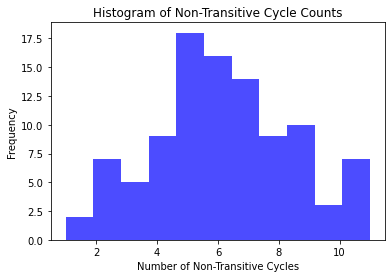

In [17]:
# Loop to sample graphs and count the number of cycles broken
n = 3
k = 2
cycle_counts = []
num_graphs = 100

theta = generate_additive_theta(n, k)

vertices = theta # Example vertices
print(theta)
graphs = {}
for _ in trange(num_graphs):
    graph = create_random_directed_graph([tuple(i) for i in theta], edge_probability = 0.5)
    g2 = list(graph)
    count = break_cycles(graph)
    graphs[count] = graphs.get(count, []) + [g2]
    cycle_counts.append(count)

# Plotting the histogram of cycle counts
plt.hist(cycle_counts, bins=max(cycle_counts) - min(cycle_counts) + 1, alpha=0.7, color='blue')
plt.title('Histogram of Non-Transitive Cycle Counts')
plt.xlabel('Number of Non-Transitive Cycles')
plt.ylabel('Frequency')
plt.show()


Now we train the map model on each of them and save for each graph : 
- The number of cycle it contains.
- The maximum accuracy achieved using only the addtive part.
- The maximum accuracy achieved using also the non transitive part.

In [5]:
data = {
    "n_cycles":[],
    "additive_acc":[],
    "nt_acc":[]
}
n_epochs = 200
lr=5e-3
m = 10
for k in tqdm(sorted(graphs.keys())):
    print("k=",k)
    L = []
    nb = 0
    if len(graphs[k]) < m:
        continue
    for s in tqdm(graphs[k][:m]):
        model_map = SSBModel(theta)
        acc1 = fit_w_map(model_map, s, num_epochs=n_epochs,  lr=5e-2,lambda_1 = 0)
        acc2 = fit_M_map(model_map, s, num_epochs=n_epochs, lr=5e-3,lambda_2 = 0)
        acc = acc1 + acc2
        #plt.plot(np.arange(len(acc)), acc)
        #plt.show()
        data["n_cycles"].append(k)
        data["additive_acc"].append(max(acc1))
        data["nt_acc"].append(max(acc2))
        L.append(max(acc2) - max(acc1))
    print(f"{k} - {np.array(L).mean()}")

  0%|          | 0/13 [00:00<?, ?it/s]

k= 0


  0%|          | 0/10 [00:00<?, ?it/s]

0 - 0.0
k= 1


  0%|          | 0/10 [00:00<?, ?it/s]

1 - 0.17297619047619048
k= 2


  0%|          | 0/10 [00:00<?, ?it/s]

2 - 0.21960317460317463
k= 3


  0%|          | 0/10 [00:00<?, ?it/s]

3 - 0.23565656565656562
k= 4


  0%|          | 0/10 [00:00<?, ?it/s]

4 - 0.28432983682983687
k= 5


  0%|          | 0/10 [00:00<?, ?it/s]

5 - 0.3376029526029526
k= 6


  0%|          | 0/10 [00:00<?, ?it/s]

6 - 0.3169380619380619
k= 7


  0%|          | 0/10 [00:00<?, ?it/s]

7 - 0.35739468864468865
k= 8


  0%|          | 0/10 [00:00<?, ?it/s]

8 - 0.38761904761904764
k= 9


  0%|          | 0/10 [00:00<?, ?it/s]

9 - 0.3325468648998061
k= 10


  0%|          | 0/10 [00:00<?, ?it/s]

10 - 0.3750560224089636
k= 11
k= 12


<AxesSubplot:xlabel='Number of Cycles', ylabel='Marginal Gain'>

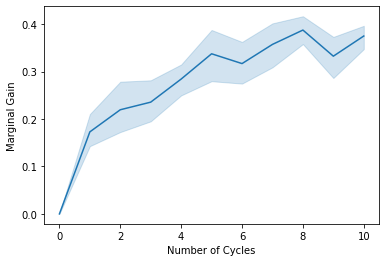

In [6]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(data)
df["marginal_gain"] = df["nt_acc"] - df["additive_acc"]
df["Marginal Gain"] = df["marginal_gain"]
df["Number of Cycles"] = df["n_cycles"]

sns.lineplot(data = df, x = "Number of Cycles", y = "Marginal Gain")

In [8]:
graphs

{3: [[((4,), (2,)),
   ((0,), (1,)),
   ((2,), (0,)),
   ((2,), (4,)),
   ((0,), (2,)),
   ((0,), (4,)),
   ((3,), (1,)),
   ((4,), (1,)),
   ((4,), (0,))],
  [((3,), (4,)),
   ((2,), (3,)),
   ((0,), (1,)),
   ((3,), (2,)),
   ((2,), (1,)),
   ((1,), (0,)),
   ((2,), (4,)),
   ((0,), (2,)),
   ((0,), (4,)),
   ((3,), (1,)),
   ((4,), (1,))],
  [((1,), (3,)),
   ((2,), (3,)),
   ((1,), (0,)),
   ((2,), (4,)),
   ((0,), (2,)),
   ((0,), (4,)),
   ((1,), (2,)),
   ((3,), (1,))],
  [((1,), (3,)),
   ((2,), (3,)),
   ((3,), (2,)),
   ((2,), (1,)),
   ((0,), (2,)),
   ((0,), (4,)),
   ((4,), (1,)),
   ((3,), (0,)),
   ((4,), (0,))],
  [((3,), (4,)),
   ((3,), (2,)),
   ((1,), (0,)),
   ((2,), (4,)),
   ((0,), (2,)),
   ((4,), (3,)),
   ((0,), (4,)),
   ((1,), (2,)),
   ((3,), (1,)),
   ((4,), (1,))],
  [((3,), (4,)),
   ((3,), (2,)),
   ((0,), (1,)),
   ((4,), (2,)),
   ((2,), (1,)),
   ((1,), (4,)),
   ((0,), (4,)),
   ((1,), (2,)),
   ((3,), (1,)),
   ((4,), (1,)),
   ((4,), (0,))],
  [((